#### 제목 : 자전거 수요 예측
##### 목표 : 주어진 데이터로부터 자전거의 수요를 예측한다
##### 문제 유형 : 회귀
##### 평가지표 : rmsle

### EDA

In [1]:
import pandas as pd
import numpy as np

In [2]:
sample=pd.read_csv('./data/sampleSubmission.csv')
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.shape, test.shape
# train data는 12개의 컬럼, test data는 9개 컬럼으로 구성됨

((10886, 12), (6493, 9))

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


```
Data Fields
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
```

In [5]:
test.head()
# 분석 결과 : casual와 registered 제외됨

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
sample.head()
# 분석 결과 : datetime 피처 제거 -> 데이터를 구분하는 역할이므로 타겟값에 영향이 없음

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [7]:
train.info()
# 결측치 없음
# 수치형 변수에 대한 이상치 탐색 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
test.info()
# 결측값 없음
# 데이터 타입이 훈련 데이터와 비슷

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [9]:
# 피쳐 엔지니어링
# datetime 에 대한 각각 연월일 시분초 별 상관성 존재 여부 파악 필요
from datetime import datetime
import calendar

train['year'] = train.datetime.map(lambda x: str(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year).zfill(4))
train['month'] = train.datetime.map(lambda x: str(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month).zfill(2))
train['day'] = train.datetime.map(lambda x: str(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').day).zfill(2))
train['hour'] = train.datetime.map(lambda x: str(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour).zfill(2))
train['minute'] = train.datetime.map(lambda x: str(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').minute).zfill(2))
train['second'] = train.datetime.map(lambda x: str(datetime.strptime(x, '%Y-%m-%d %H:%M:%S').second).zfill(2))
train['weekday'] = train.datetime.map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday()) # ML 수행시
train['weekday_str'] = train.datetime.map(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday()]) # 분석시
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,weekday,weekday_str
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,01,01,00,00,00,5,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,01,01,01,00,00,5,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,01,01,02,00,00,5,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,01,01,03,00,00,5,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,01,01,04,00,00,5,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,00,00,2,Wednesday
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,00,00,2,Wednesday
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,00,00,2,Wednesday
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,00,00,2,Wednesday


In [10]:
# 계절은 1,2,3  4,5,6  7,8,9 10,11,12 각 세달씩 묶으면 season이 될 수 있다
# 세분화된 데이터를 더 큰 분류로 묶으면 성능이 좋아지는 경우가 있어 month 피처를 제거
# 분석 결과 : month 제거
train['season_str'] = train.season.map({1: 'spring',      
                                        2: 'summer',      
                                        3: 'fall',
                                        4: 'winter'})
train['weather_str'] = train.weather.map({1: 'Clear',
                                          2: 'Mist, Cloudy',
                                          3: 'Light Snow, Light Rain',
                                          4: ' Heavy Rain, Ice Pallets, Thunderstorm'
                                         })


In [11]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,year,month,day,hour,minute,second,weekday,weekday_str,season_str,weather_str
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,...,2011,01,01,00,00,00,5,Saturday,spring,Clear
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,...,2011,01,01,01,00,00,5,Saturday,spring,Clear
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,...,2011,01,01,02,00,00,5,Saturday,spring,Clear
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,...,2011,01,01,03,00,00,5,Saturday,spring,Clear
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,...,2011,01,01,04,00,00,5,Saturday,spring,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,...,2012,12,19,19,00,00,2,Wednesday,winter,Clear
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,...,2012,12,19,20,00,00,2,Wednesday,winter,Clear
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,...,2012,12,19,21,00,00,2,Wednesday,winter,Clear
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,...,2012,12,19,22,00,00,2,Wednesday,winter,Clear


### 데이터 시각화

In [12]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
mpl.rc('font', size=15) # 폰트 크기 15로 설정

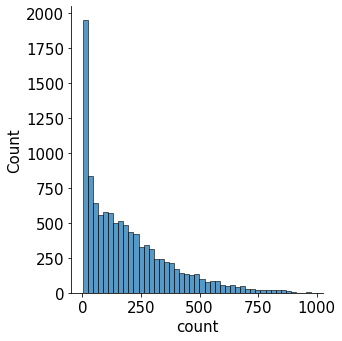

In [14]:
# 타켓값 분포도 시각화
sns.displot(train['count'])
# 대부분의 날은 빌리지 않았고, 많이 빌린날이 적군,, 비대칭 분포~!!
# 정규분포와 비슷하게 해줘야 예측력이 좋으므로 로그변환 필요

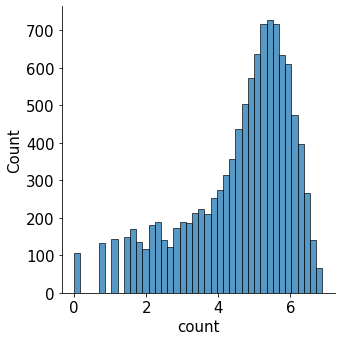

In [15]:
# 타겟값 로그변환
# 로그 변환 전보다 정규성을 보이는 형태
# 분석결과 : 타겟값을 count가 아닌 log(count)로 변환하여 사용!!!, 예측후 지수변환하여 count 계산 np.exp() 활용!!
sns.displot(np.log(train['count']))

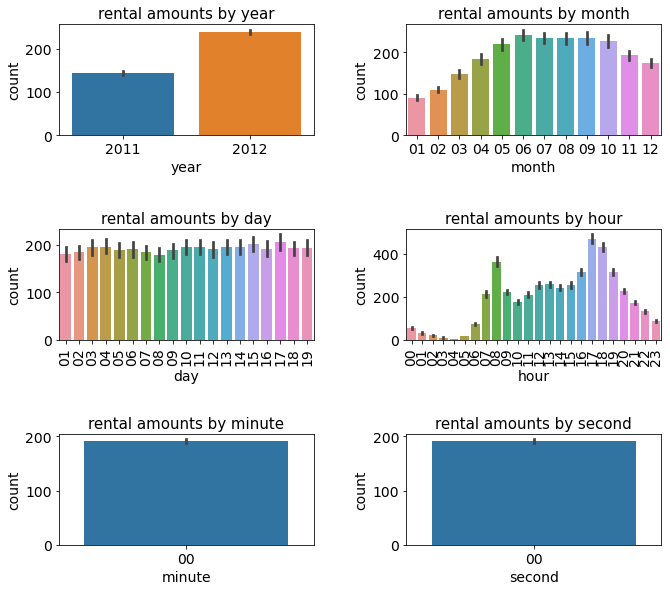

In [16]:
# figure 준비
mpl.rc('font', size=14) # 폰트 크기 설정
mpl.rc('axes', titlesize=15) # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) # 3행 2열 figure 생성
plt.tight_layout() # 그래프 사이 여백 확보
figure.set_size_inches(10,9) # 전체 figure 크기를 10*9로 설정

# 각 축에 서브플롯 할당
sns.barplot(x='year', y='count', data=train, ax=axes[0,0])
sns.barplot(x='month', y='count', data=train, ax=axes[0,1])
sns.barplot(x='day', y='count', data=train, ax=axes[1,0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1,1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2,0])
sns.barplot(x='second', y='count', data=train, ax=axes[2,1])

axes[0,0].set(title='rental amounts by year')
axes[0,1].set(title='rental amounts by month')
axes[1,0].set(title='rental amounts by day')
axes[1,1].set(title='rental amounts by hour')
axes[2,0].set(title='rental amounts by minute')
axes[2,1].set(title='rental amounts by second')


axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,1].tick_params(axis='x', labelrotation=90)
# 분석 결과 : day, minute, second 피처 제가 가능

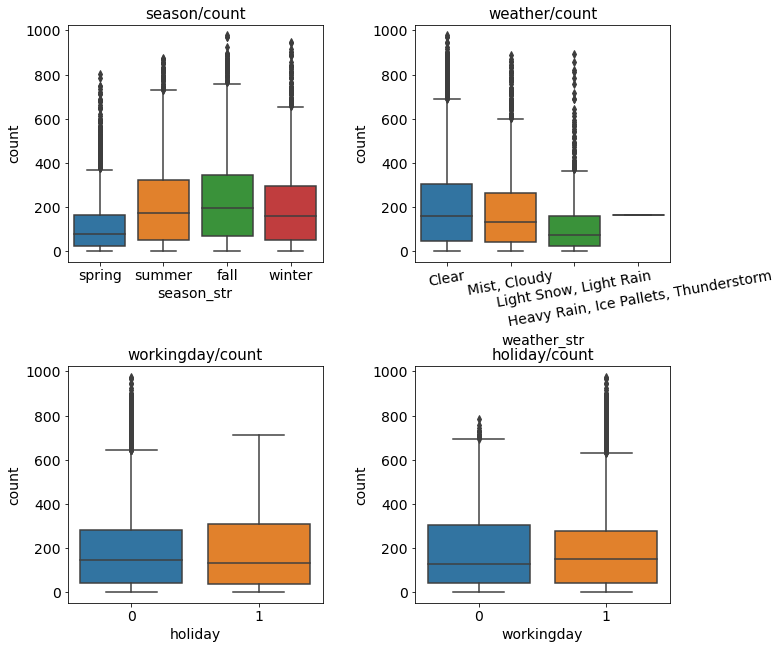

In [17]:
# 'season', 'holiday', 'workingday', 'weather' 별 count 시각화
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(10, 10)

sns.boxplot(x='season_str', y='count', data=train, ax=axes[0,0])
sns.boxplot(x='weather_str', y='count', data=train, ax=axes[0,1])
sns.boxplot(x='holiday', y='count', data=train, ax=axes[1,0])
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1,1])

axes[0,0].set(title='season/count')
axes[0,1].set(title='weather/count')
axes[1,1].set(title='holiday/count')
axes[1,0].set(title='workingday/count')

axes[0,1].tick_params(axis='x', labelrotation=10)

<AxesSubplot:xlabel='hour', ylabel='count'>

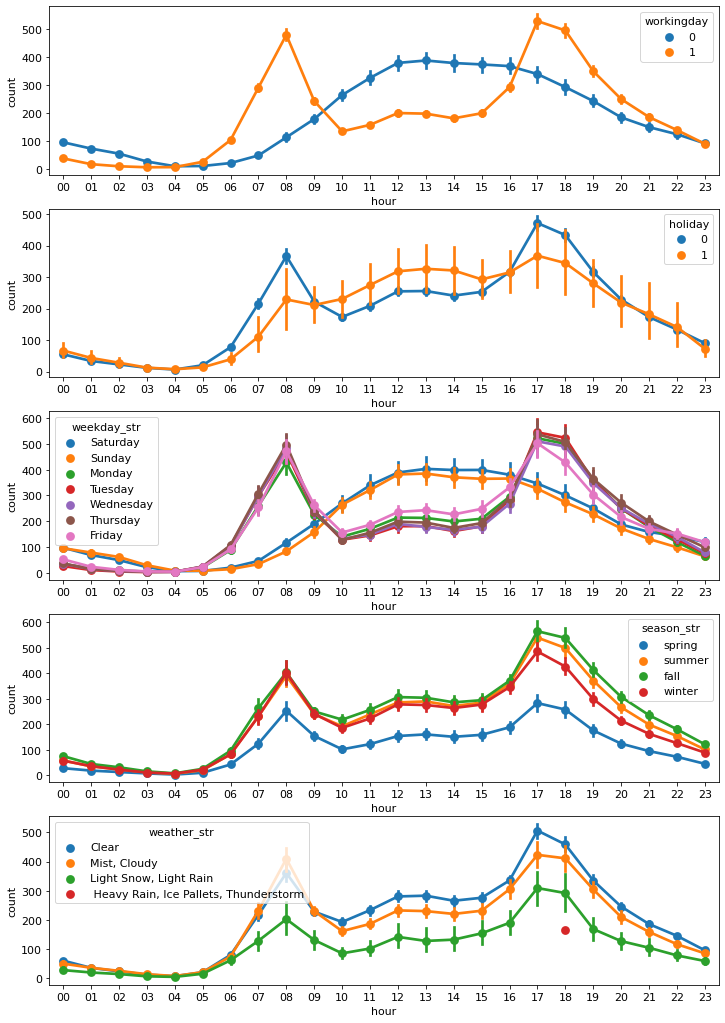

In [18]:
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5)
figure.set_size_inches(12,18)

sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday_str', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season_str', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather_str', ax=axes[4])

# 분석 결과 : weather == 4 인 데이터 이상치로 삭제

[Text(0.5, 1.0, 'windspeed/count')]

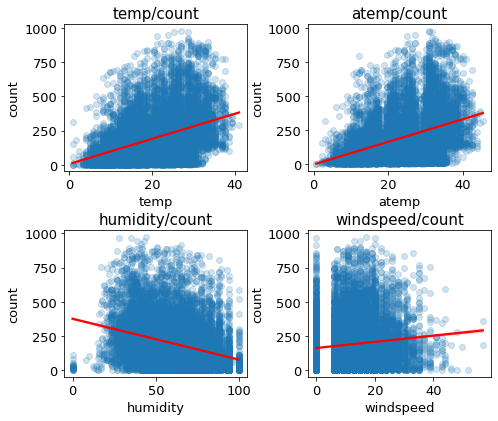

In [19]:
# 온도, 체감온도, 풍속, 습도별 대여 수량 시각화 (회귀선 + 산점도)
mpl.rc('font', size=13)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout()
figure.set_size_inches(7,6)

sns.regplot(x='temp', y='count', data=train, ax=axes[0,0], scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
sns.regplot(x='atemp', y='count', data=train, ax=axes[0,1], scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
sns.regplot(x='humidity', y='count', data=train, ax=axes[1,0], scatter_kws={'alpha':0.2}, line_kws={'color':'red'})
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1,1], scatter_kws={'alpha':0.2}, line_kws={'color':'red'})

axes[0,0].set(title='temp/count')
axes[0,1].set(title='atemp/count')
axes[1,0].set(title='humidity/count')
axes[1,1].set(title='windspeed/count')

# 0에 대한 이상치 조치
# windspeed -> 0을 평균값으로 대치 
#              또는 피처 제거
# 분석 결과 : windspeed 피처 삭제

[Text(0.5, 1.0, 'heatmap of numerical data')]

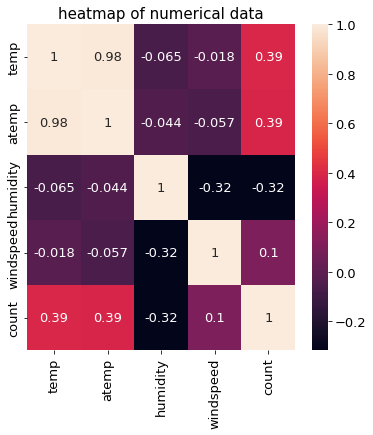

In [20]:
corrMat = train[['temp','atemp', 'humidity', 'windspeed', 'count']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
sns.heatmap(corrMat,annot=True)
ax.set(title='heatmap of numerical data')

# 분석 결과 count 와 windspeed 와의 상관관계가 약하므로 피처 제거